Socks, Skeets, and Space Invaders
---------------------------------

This notebook contains code from my blog, [Probably Overthinking It](http://allendowney.blogspot.com/)

Copyright 2016 Allen Downey

MIT License: http://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from thinkbayes2 import Pmf, Hist, Beta
import thinkbayes2
import thinkplot

### Socks

The sock drawer problem
Posed by Yuzhong Huang:

> There are two drawers of socks. The first drawer has 40 white socks and 10 black socks; the second drawer has 20 white socks and 30 black socks.  We randomly get 2 socks from a drawer, and it turns out to be a pair (same color) but we don't know the color of these socks. What is the chance that we picked the first drawer?



Now I'll solve the problem more generally using a Jupyter notebook.

I'll represent the sock drawers with `Hist` objects, defined in the `thinkbayes2` library:

In [2]:
drawer1 = Hist(dict(W=40, B=10), label='Drawer 1')
drawer2 = Hist(dict(W=20, B=30), label='Drawer 2')
drawer1.Print()

B 10
W 40


Now I can make a `Pmf` that represents the two hypotheses:

In [3]:
pmf = Pmf([drawer1, drawer2])
pmf.Print()

Drawer 2 0.5
Drawer 1 0.5


This function computes the likelihood of the data for a given hypothesis:

In [4]:
def likelihood(data, hypo):
    """Likelihood of the data under the hypothesis.
    
    data: string 'same' or 'different'
    hypo: Hist object with the number of each color
    
    returns: float likelihood
    """
    probs = Pmf(hypo)
    prob_same = probs['W']**2 + probs['B']**2
    if data == 'same':
        return prob_same
    else:
        return 1-prob_same

Now we can update `pmf` with these likelihoods

In [5]:
data = 'same'

pmf[drawer1] *= likelihood(data, drawer1)
pmf[drawer2] *= likelihood(data, drawer2)
pmf.Normalize()

0.6000000000000001

The return value from Normalize is the total probability of the data, the denominator of Bayes's theorem, also known as the normalizing constant.

And here's the posterior distribution:

In [6]:
pmf.Print()

Drawer 2 0.433333333333
Drawer 1 0.566666666667


The likelihood of getting a pair is higher in Drawer 1, which is 40:10, than in Drawer 2, which is 30:20.

In general, the probability of getting a pair is highest if the drawer contains only one color sock, and lowest if the proportion if 50:50.

So getting a pair is evidence that the drawer is more likely to have a high (or low) proportion of one color, and less likely to be balanced.

## The Alien Blaster problem

In preparation for an alien invasion, the Earth Defense League has been working on new missiles to shoot down space invaders.  Of course, some missile designs are better than others; let's assume that each design has some probability of hitting an alien ship, x.

Based on previous tests, the distribution of x in the population of designs is roughly uniform between 10% and 40%.  To approximate this distribution, we'll assume that x is either 10%, 20%, 30%, or 40% with equal probability.

Now suppose the new ultra-secret Alien Blaster 10K is being tested.  In a press conference, an EDF general reports that the new design has been tested twice, taking two shots during each test.  The results of the test are confidential, so the general won't say how many targets were hit, but they report: ``The same number of targets were hit in the two tests, so we have reason to think this new design is consistent.''

Is this data good or bad; that is, does it increase or decrease your estimate of x for the Alien Blaster 10K?

I'll start by creating a `Pmf` that represents the four hypothetical values of `x`:

In [7]:
pmf = Pmf([0.1, 0.2, 0.3, 0.4])
pmf.Print()

0.1 0.25
0.2 0.25
0.3 0.25
0.4 0.25


Before seeing the data, the mean of the distribution, which is the expected effectiveness of the blaster, is 0.25.

In [8]:
pmf.Mean()

0.25

Here's how we compute the likelihood of the data.  If each blaster takes two shots, there are three ways they can get a tie: they both get 0, 1, or 2.  If the probability that either blaster gets a hit is x, the probabilities of these outcomes are:

    both 0:  (1-x)**4
    both 1:  (2 * x * (1-x))**2
    both 2:  x**x
    
Here's the likelihood function that computes the total probability of the three outcomes:

In [9]:
def likelihood(hypo, data):
    """Likelihood of the data under hypo.
    
    hypo: probability of a hit, x
    data: 'tie' or 'no tie'
    """
    x = hypo
    like = x**4 + (2 * x * (1-x))**2 + (1-x)**4
    if data == 'tie':
        return like
    else:
        return 1-like

To see what the likelihood function looks like, I'll print the likelihood of a tie for the four hypothetical values of `x`: 

In [10]:
data = 'tie'
for hypo in sorted(pmf):
    like = likelihood(hypo, data)
    print(hypo, like)

0.1 0.6886
0.2 0.5136
0.3 0.4246
0.4 0.3856


If we multiply each likelihood by the corresponding prior, we get the unnormalized posteriors:

In [11]:
for hypo in sorted(pmf):
    unnorm_post = pmf[hypo] * likelihood(hypo, data)
    print(hypo, pmf[hypo], unnorm_post)

0.1 0.25 0.17215
0.2 0.25 0.1284
0.3 0.25 0.10615
0.4 0.25 0.0964


Finally, we can do the update by multiplying the priors in `pmf` by the likelihoods:

In [12]:
for hypo in pmf:
    pmf[hypo] *= likelihood(hypo, data)

And then normalizing `pmf`.  The result is the total probability of the data.

In [13]:
pmf.Normalize()

0.5031000000000001

And here are the posteriors.

In [14]:
pmf.Print()

0.1 0.342178493341
0.2 0.255217650566
0.3 0.210991850527
0.4 0.191612005565


The lower values of `x` are more likely, so this evidence makes us downgrade our expectation about the effectiveness of the blaster.  The posterior mean is 0.225, a bit lower than the prior mean, 0.25.

In [15]:
pmf.Mean()

0.2252037368316438

A tie is evidence in favor of extreme values of `x`.

## The Skeet Shooting problem

At the 2016 Summer Olympics in the Women's Skeet event, Kim Rhode faced Wei Meng in the bronze medal match.  After 25 shots, they were tied, sending the match into sudden death.  In each round of sudden death, each competitor shoots at two targets.  In the first three rounds, Rhode and Wei hit the same number of targets.  Finally in the fourth round, Rhode hit more targets, so she won the bronze medal, making her the first Summer Olympian to win an individual medal at six consecutive summer games.  Based on this information, should we infer that Rhode and Wei had an unusually good or bad day?

As background information, you can assume that anyone in the Olympic final has about the same probability of hitting 13, 14, 15, or 16 out of 25 targets.

To compute the likelihood function, I'll use `binom.pmf`, which computes the Binomial PMF.  In the following example, the probability of hitting `k=10` targets in `n=25` attempts, with probability `p=13/15` of hitting each target, is about 8%.

In [16]:
from scipy.stats import binom

k = 10
n = 25
p = 13/25
binom.pmf(k, n, p)

0.078169085615240511

The following function computes the likelihood of `tie` or `no tie` after a given number of shots, `n`, given the hypothetical value of `p`.

It loops through the possible values of `k` from 0 to `n` and uses `binom.pmf` to compute the probability that each shooter hits `k` targets.  To get the probability that BOTH shooters hit `k` targets, we square the result.

To get the total likelihood of the outcome, we add up the probability for each value of `k`.

In [17]:
def likelihood(data, hypo):
    """Likelihood of data under hypo.
        
    data: tuple of (number of shots, 'tie' or 'no tie')
    hypo: hypothetical number of hits out of 25
    """
    p = hypo / 25
    n, outcome = data
    like = sum([binom.pmf(k, n, p)**2 for k in range(n+1)])
    return like if outcome=='tie' else 1-like

Now we can see what that looks like for `n=2`

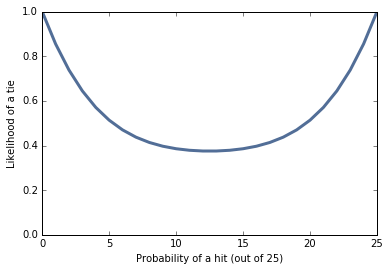

In [18]:
data = 2, 'tie'

hypos = range(0, 26)
likes = [likelihood(data, hypo) for hypo in hypos]
thinkplot.Plot(hypos, likes)
thinkplot.Config(xlabel='Probability of a hit (out of 25)',
                 ylabel='Likelihood of a tie',
                 ylim=[0, 1])

As we saw in the Sock Drawer problem and the Alien Blaster problem, the probability of a tie is highest for extreme values of `p`, and minimized when `p=0.5`.

The result is similar when `n=25`:

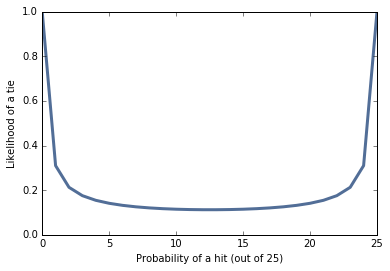

In [19]:
data = 25, 'tie'

hypos = range(0, 26)
likes = [likelihood(data, hypo) for hypo in hypos]
thinkplot.Plot(hypos, likes)
thinkplot.Config(xlabel='Probability of a hit (out of 25)',
                 ylabel='Likelihood of a tie',
                 ylim=[0, 1])

In the range we care about (13 through 16) this curve is pretty flat, which means that a tie after the round of 25 doesn't discriminate strongly among the hypotheses.

We could use this likelihood function to run the update, but just for purposes of demonstration, I'll do it using the Suite class from `thinkbayes2`:

In [20]:
from thinkbayes2 import Suite

class Skeet(Suite):
    
    def Likelihood(self, data, hypo):
        """Likelihood of data under hypo.
        
        data: tuple of (number of shots, 'tie' or 'no tie')
        hypo: hypothetical number of hits out of 25
        """
        p = hypo / 25
        n, outcome = data
        like = sum([binom.pmf(k, n, p)**2 for k in range(n+1)])
        return like if outcome=='tie' else 1-like

Now I'll create the prior.

In [21]:
suite = Skeet([13, 14, 15, 16])
suite.Print()

13 0.25
14 0.25
15 0.25
16 0.25


The prior mean is 14.5.

In [22]:
suite.Mean()

14.5

In [23]:
suite.Update((25, 'tie'))
suite.Print()

13 0.245787744767
14 0.247411480833
15 0.250757985003
16 0.256042789397


The higher values are a little more likely, but the effect is pretty small.

Interestingly, the rounds of `n=2` provide more evidence in favor of the higher values of `p`.

In [24]:
suite.Update((2, 'tie'))
suite.Print()

13 0.240111712333
14 0.243807684231
15 0.251622537592
16 0.264458065844


In [25]:
suite.Update((2, 'tie'))
suite.Print()

13 0.234458172307
14 0.240145161205
15 0.252373188397
16 0.273023478091


In [26]:
suite.Update((2, 'tie'))
suite.Print()

13 0.228830701632
14 0.236427057892
15 0.253007722855
16 0.28173451762


After three rounds of sudden death, we are more inclined to think that the shooters are having a good day.

The fourth round, which ends with no tie, provides a small amount of evidence in the other direction.

In [27]:
suite.Update((2, 'no tie'))
suite.Print()

13 0.2323322732
14 0.23878553469
15 0.252684685857
16 0.276197506253


And the posterior mean, after all updates, is a little higher than 14.5, where we started.

In [28]:
suite.Mean()

14.572747425162735

In summary, the outcome of this match, with four rounds of sudden death, provides weak evidence that the shooters were having a good day.

In general for this kind of contest, a tie is more likely if the probability of success is very high or low.

In the Alien Blaster problem, the hypothetical value of `p` are all less than 50%, so a tie causes us to revise beliefs about `p` downward.

In the Skeet Shooter problem, the hypothetical values are greater than 50%, so ties make us revise our estimates upward.